<a href="https://colab.research.google.com/github/ensarakbas77/Match-Result-Prediction/blob/main/Informer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
)
import time
import math
import copy

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

'/device:GPU:0'

In [ ]:
file_path= 'Matches.xlsx'
df=pd.read_excel(file_path)

In [ ]:
# Sadece geçerli sonuçları tut
df = df[df['Sonuç'].isin([-1, 0, 1])]

# Haritalama işlemi
sonuc_mapping = {-1: 0, 0: 1, 1: 2}
df['Sonuç'] = df['Sonuç'].map(sonuc_mapping)

# **Veri Setiyle Alakalı Bilgiler**

In [ ]:
df.head(-5)

,Tarih,Takım ID,Rakip Takım ID,Is_Home,Sonuç,Gol,Rakip Gol,Topla Oynama(%),Şut,İsabetli Şut,...,Rakip Korner,Rakip Orta,Rakip Faul,Rakip Ofsayt,Şut Verimliliği,Sezon,Ay,Haftanın Günü,Son 5 Maç Gol Ort,Son 5 Maç Galibiyet Oranı
0,2011-07-30 17:00:00,6,7,0,2,3,2,50,12,5,...,6,2,15,2,0.416667,2011,7,6,3.0,1.0
1,2011-08-06 19:15:00,6,8,1,2,2,1,60,7,6,...,3,4,20,1,0.857143,2011,8,6,2.5,1.0
2,2012-08-01 02:00:00,6,9,0,2,2,1,55,14,3,...,2,1,21,0,0.214286,2012,8,3,2.0,1.0
3,2012-08-05 17:00:00,6,10,0,2,1,0,54,5,3,...,1,1,21,1,0.600000,2012,8,7,1.5,1.0
4,2012-08-09 23:10:00,6,11,0,0,0,2,40,6,2,...,4,6,19,2,0.333333,2012,8,4,1.0,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3724,2025-04-01 22:00:00,4,78,0,0,0,1,68,23,6,...,3,3,5,1,0.260870,2025,4,2,1.8,0.4
3725,2025-04-02 21:45:00,2,73,1,2,2,0,72,18,5,...,0,1,8,1,0.277778,2025,4,3,1.8,0.6
3726,2025-04-02 22:00:00,1,38,1,2,1,0,74,17,3,...,5,1,11,4,0.176471,2025,4,3,1.2,0.6
3727,2025-04-03 22:00:00,6,3,0,0,0,1,50,8,2,...,4,5,7,5,0.250000,2025,4,4,1.0,0.2


,Tarih,Takım ID,Rakip Takım ID,Is_Home,Sonuç,Gol,Rakip Gol,Topla Oynama(%),Şut,İsabetli Şut,...,Rakip Korner,Rakip Orta,Rakip Faul,Rakip Ofsayt,Şut Verimliliği,Sezon,Ay,Haftanın Günü,Son 5 Maç Gol Ort,Son 5 Maç Galibiyet Oranı
0,2011-07-30 17:00:00,6,7,0,2,3,2,50,12,5,...,6,2,15,2,0.416667,2011,7,6,3.0,1.0
1,2011-08-06 19:15:00,6,8,1,2,2,1,60,7,6,...,3,4,20,1,0.857143,2011,8,6,2.5,1.0
2,2012-08-01 02:00:00,6,9,0,2,2,1,55,14,3,...,2,1,21,0,0.214286,2012,8,3,2.0,1.0
3,2012-08-05 17:00:00,6,10,0,2,1,0,54,5,3,...,1,1,21,1,0.600000,2012,8,7,1.5,1.0
4,2012-08-09 23:10:00,6,11,0,0,0,2,40,6,2,...,4,6,19,2,0.333333,2012,8,4,1.0,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3724,2025-04-01 22:00:00,4,78,0,0,0,1,68,23,6,...,3,3,5,1,0.260870,2025,4,2,1.8,0.4
3725,2025-04-02 21:45:00,2,73,1,2,2,0,72,18,5,...,0,1,8,1,0.277778,2025,4,3,1.8,0.6
3726,2025-04-02 22:00:00,1,38,1,2,1,0,74,17,3,...,5,1,11,4,0.176471,2025,4,3,1.2,0.6
3727,2025-04-03 22:00:00,6,3,0,0,0,1,50,8,2,...,4,5,7,5,0.250000,2025,4,4,1.0,0.2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3734 entries, 0 to 3733
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Tarih                      3734 non-null   datetime64[ns]
 1   Takım ID                   3734 non-null   int64         
 2   Rakip Takım ID             3734 non-null   int64         
 3   Is_Home                    3734 non-null   int64         
 4   Sonuç                      3734 non-null   int64         
 5   Gol                        3734 non-null   int64         
 6   Rakip Gol                  3734 non-null   int64         
 7   Topla Oynama(%)            3734 non-null   int64         
 8   Şut                        3734 non-null   int64         
 9   İsabetli Şut               3734 non-null   int64         
 10  Başarılı Pas               3734 non-null   int64         
 11  Pas Başarısı(%)            3734 non-null   int64         
 12  Korner

In [ ]:
df.isnull().sum()

,0
Tarih,0
Takım ID,0
Rakip Takım ID,0
Is_Home,0
Sonuç,0
Gol,0
Rakip Gol,0
Topla Oynama(%),0
Şut,0
İsabetli Şut,0


,0
Tarih,0
Takım ID,0
Rakip Takım ID,0
Is_Home,0
Sonuç,0
Gol,0
Rakip Gol,0
Topla Oynama(%),0
Şut,0
İsabetli Şut,0


In [ ]:
df.describe()

,Tarih,Takım ID,Rakip Takım ID,Is_Home,Sonuç,Gol,Rakip Gol,Topla Oynama(%),Şut,İsabetli Şut,...,Rakip Korner,Rakip Orta,Rakip Faul,Rakip Ofsayt,Şut Verimliliği,Sezon,Ay,Haftanın Günü,Son 5 Maç Gol Ort,Son 5 Maç Galibiyet Oranı
count,3734,3734.000000,3734.000000,3734.000000,3734.000000,3734.000000,3734.000000,3734.000000,3734.000000,3734.000000,...,3734.000000,3734.000000,3734.000000,3734.000000,3733.000000,3734.000000,3734.000000,3734.000000,3734.000000,3734.000000
mean,2019-06-30 14:24:11.858596864,3.512587,64.539636,0.501071,1.389127,2.014997,1.029191,58.925013,15.407070,5.731387,...,4.046063,3.382164,10.735404,2.053294,0.380349,2018.980718,6.664167,4.847616,1.968041,0.577338
min,2011-07-30 17:00:00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2011.000000,1.000000,1.000000,0.000000,0.000000
25%,2016-08-27 17:37:30,2.000000,20.000000,0.000000,1.000000,1.000000,0.000000,52.000000,11.000000,4.000000,...,2.000000,2.000000,8.000000,1.000000,0.281250,2016.000000,3.000000,3.000000,1.400000,0.400000
50%,2019-05-24 08:30:00,4.000000,39.000000,1.000000,2.000000,2.000000,1.000000,60.000000,15.000000,5.000000,...,4.000000,3.000000,11.000000,2.000000,0.375000,2019.000000,7.000000,6.000000,2.000000,0.600000
75%,2022-04-27 16:00:00,5.000000,86.000000,1.000000,2.000000,3.000000,2.000000,67.000000,19.000000,7.000000,...,6.000000,5.000000,13.000000,3.000000,0.466667,2022.000000,10.000000,6.000000,2.400000,0.800000
max,2025-04-10 22:00:00,6.000000,294.000000,1.000000,2.000000,9.000000,7.000000,84.000000,58.000000,20.000000,...,17.000000,16.000000,27.000000,11.000000,1.000000,2025.000000,12.000000,7.000000,6.000000,1.000000
std,NaN,1.709157,65.842952,0.500066,0.812374,1.499277,1.064969,10.648803,6.049383,2.847851,...,2.585691,2.377210,3.735588,1.664652,0.146041,3.374421,3.815630,1.935492,0.732422,0.230579


,Tarih,Takım ID,Rakip Takım ID,Is_Home,Sonuç,Gol,Rakip Gol,Topla Oynama(%),Şut,İsabetli Şut,...,Rakip Korner,Rakip Orta,Rakip Faul,Rakip Ofsayt,Şut Verimliliği,Sezon,Ay,Haftanın Günü,Son 5 Maç Gol Ort,Son 5 Maç Galibiyet Oranı
count,3734,3734.000000,3734.000000,3734.000000,3734.000000,3734.000000,3734.000000,3734.000000,3734.000000,3734.000000,...,3734.000000,3734.000000,3734.000000,3734.000000,3733.000000,3734.000000,3734.000000,3734.000000,3734.000000,3734.000000
mean,2019-06-30 14:24:11.858596864,3.512587,64.539636,0.501071,1.389127,2.014997,1.029191,58.925013,15.407070,5.731387,...,4.046063,3.382164,10.735404,2.053294,0.380349,2018.980718,6.664167,4.847616,1.968041,0.577338
min,2011-07-30 17:00:00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2011.000000,1.000000,1.000000,0.000000,0.000000
25%,2016-08-27 17:37:30,2.000000,20.000000,0.000000,1.000000,1.000000,0.000000,52.000000,11.000000,4.000000,...,2.000000,2.000000,8.000000,1.000000,0.281250,2016.000000,3.000000,3.000000,1.400000,0.400000
50%,2019-05-24 08:30:00,4.000000,39.000000,1.000000,2.000000,2.000000,1.000000,60.000000,15.000000,5.000000,...,4.000000,3.000000,11.000000,2.000000,0.375000,2019.000000,7.000000,6.000000,2.000000,0.600000
75%,2022-04-27 16:00:00,5.000000,86.000000,1.000000,2.000000,3.000000,2.000000,67.000000,19.000000,7.000000,...,6.000000,5.000000,13.000000,3.000000,0.466667,2022.000000,10.000000,6.000000,2.400000,0.800000
max,2025-04-10 22:00:00,6.000000,294.000000,1.000000,2.000000,9.000000,7.000000,84.000000,58.000000,20.000000,...,17.000000,16.000000,27.000000,11.000000,1.000000,2025.000000,12.000000,7.000000,6.000000,1.000000
std,NaN,1.709157,65.842952,0.500066,0.812374,1.499277,1.064969,10.648803,6.049383,2.847851,...,2.585691,2.377210,3.735588,1.664652,0.146041,3.374421,3.815630,1.935492,0.732422,0.230579


In [ ]:
print("Veri şekli:", df.shape)

Veri şekli: (3734, 31)
Veri şekli: (3734, 31)


# **SINIF DAĞILIMLARI**

Sınıf Dağılımı: Counter({2: 2241, 0: 788, 1: 705})


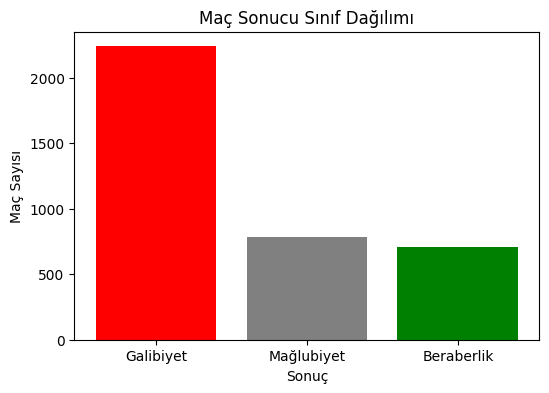

Sınıf Dağılımı: Counter({2: 2241, 0: 788, 1: 705})


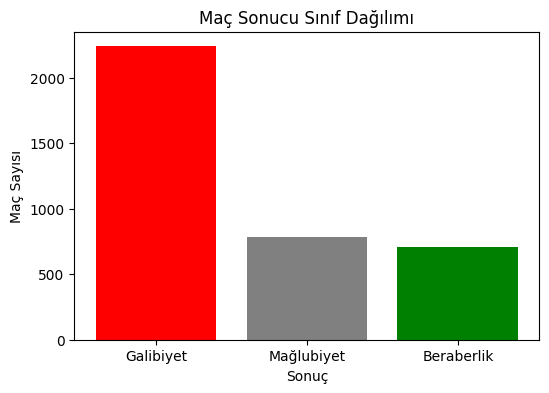

In [ ]:
sonuclar = df["Sonuç"]
dağılım = Counter(sonuclar)

etiket_map = {0: "Mağlubiyet", 1: "Beraberlik", 2: "Galibiyet"}
etiketler = [etiket_map.get(s, s) for s in dağılım.keys()]
sayılar = list(dağılım.values())

print("Sınıf Dağılımı:", dağılım)

plt.figure(figsize=(6, 4))
plt.bar(etiketler, sayılar, color=["red", "gray", "green"])
plt.title("Maç Sonucu Sınıf Dağılımı")
plt.xlabel("Sonuç")
plt.ylabel("Maç Sayısı")
plt.show()

In [ ]:
df.corr()["Sonuç"].sort_values()

,Sonuç
Rakip Gol,-0.612275
Rakip İsabetli Şut,-0.387845
Rakip Şut,-0.254661
Rakip Topla Oynama(%),-0.123043
Faul,-0.116704
Rakip Başarılı Pas,-0.111819
Rakip Faul,-0.100061
Takım ID,-0.083692
Rakip Korner,-0.081992
Rakip Pas Başarısı(%),-0.044472


,Sonuç
Rakip Gol,-0.612275
Rakip İsabetli Şut,-0.387845
Rakip Şut,-0.254661
Rakip Topla Oynama(%),-0.123043
Faul,-0.116704
Rakip Başarılı Pas,-0.111819
Rakip Faul,-0.100061
Takım ID,-0.083692
Rakip Korner,-0.081992
Rakip Pas Başarısı(%),-0.044472


# **SEKANS VE STATİK ÖZELLİKLER**

In [ ]:
# Takıma ve tarihe göre sırala
df = df.sort_values(by=['Takım ID', 'Tarih'])

# Boş değeri doldur
df["Şut Verimliliği"] = df["Şut Verimliliği"].fillna(df["Şut Verimliliği"].mean())

# Feature listeleri
sequence_features = [
    'Gol', 'Rakip Gol', 'Topla Oynama(%)', 'Şut', 'İsabetli Şut', 'Başarılı Pas',
    'Pas Başarısı(%)', 'Korner', 'Orta', 'Faul', 'Ofsayt',
    'Rakip Topla Oynama(%)', 'Rakip Şut', 'Rakip İsabetli Şut', 'Rakip Başarılı Pas',
    'Rakip Pas Başarısı(%)', 'Rakip Korner', 'Rakip Orta', 'Rakip Faul', 'Rakip Ofsayt'
]

static_features = [
    'Takım ID', 'Rakip Takım ID', 'Is_Home', 'Sezon', 'Ay', 'Haftanın Günü',
    'Şut Verimliliği', 'Son 5 Maç Gol Ort', 'Son 5 Maç Galibiyet Oranı'
]


feature_means = df[sequence_features].mean().values

def pad_sequence(seq, K, mean_vec):
    if len(seq) < K:
        padding = np.tile(mean_vec, (K - len(seq), 1))
        return np.vstack([padding, seq])
    return seq


K = 10
X_seq = []
X_static = []
y = []

for idx, row in df.iterrows():
    takim_id = row['Takım ID']
    rakip_id = row['Rakip Takım ID']
    tarih = row['Tarih']

    takim_gecmis = df[(df['Takım ID'] == takim_id) & (df['Tarih'] < tarih)].sort_values(by='Tarih').tail(K)

    rakip_gecmis = df[(df['Takım ID'] == rakip_id) & (df['Tarih'] < tarih)].sort_values(by='Tarih').tail(K)

    #if len(takim_gecmis) < 1 or len(rakip_gecmis) < 1:
        #continue

    takim_seq = pad_sequence(takim_gecmis[sequence_features].values, K, feature_means)
    rakip_seq = pad_sequence(rakip_gecmis[sequence_features].values, K, feature_means)

    full_seq = np.vstack([takim_seq, rakip_seq])

    static_vec = row[static_features].values.astype(np.float32)
    label = row['Sonuç']

    X_seq.append(full_seq)
    X_static.append(static_vec)
    y.append(label)


In [ ]:
X_seq = np.array(X_seq, dtype=np.float32)
X_static = np.array(X_static, dtype=np.float32)
y = np.array(y, dtype=np.int64)

print("X_seq shape     :", X_seq.shape)
print("X_static shape  :", X_static.shape)
print("y shape         :", y.shape)
print("Sınıf dağılımı  :", Counter(y))


X_seq shape     : (3734, 20, 20)
X_static shape  : (3734, 9)
y shape         : (3734,)
Sınıf dağılımı  : Counter({np.int64(2): 2241, np.int64(0): 788, np.int64(1): 705})
X_seq shape     : (3734, 20, 20)
X_static shape  : (3734, 9)
y shape         : (3734,)
Sınıf dağılımı  : Counter({np.int64(2): 2241, np.int64(0): 788, np.int64(1): 705})


In [ ]:
X_seq = np.array(X_seq, dtype=np.float32)
X_static = np.array(X_static, dtype=np.float32)

i = 2555  # örnek indeks

takim_seq = X_seq[i][:10]   # ilk 10 zaman adımı = takım
rakip_seq = X_seq[i][10:]   # son 10 zaman adımı = rakip

print(f"Takım Sekansı ({i}. örnek):")
print(pd.DataFrame(takim_seq, columns=sequence_features))

print(f"\nRakip Sekansı ({i}. örnek):")
print(pd.DataFrame(rakip_seq, columns=sequence_features))

print("\nStatik Özellikler:")
print(dict(zip(static_features, X_static[i])))


Takım Sekansı (2555. örnek):
   Gol  Rakip Gol  Topla Oynama(%)   Şut  İsabetli Şut  Başarılı Pas  \
0  0.0        2.0             56.0   5.0           1.0         383.0   
1  3.0        0.0             71.0   9.0           3.0         737.0   
2  1.0        2.0             56.0   6.0           4.0         399.0   
3  4.0        1.0             51.0  12.0           6.0         393.0   
4  2.0        2.0             66.0  25.0           9.0         616.0   
5  2.0        1.0             64.0  13.0           4.0         534.0   
6  2.0        0.0             57.0  15.0           5.0         441.0   
7  3.0        0.0             68.0  32.0          12.0         542.0   
8  3.0        3.0             65.0  18.0           6.0         525.0   
9  1.0        2.0             52.0  12.0           4.0         382.0   

   Pas Başarısı(%)  Korner  Orta  Faul  Ofsayt  Rakip Topla Oynama(%)  \
0             77.0     1.0   1.0  16.0     4.0                   44.0   
1             90.0     5.0   3.0

# **Eğitim & Test Ayrımı**

In [ ]:
val_ratio = 0.15
test_ratio = 0.15

total_samples = len(X_seq)
test_size = int(total_samples * test_ratio)
val_size = int(total_samples * val_ratio)
train_size = total_samples - val_size - test_size

X_seq_train = X_seq[:train_size]
X_static_train = X_static[:train_size]
y_train = y[:train_size]

X_seq_val = X_seq[train_size:train_size + val_size]
X_static_val = X_static[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_seq_test = X_seq[-test_size:]
X_static_test = X_static[-test_size:]
y_test = y[-test_size:]


print("Train:", len(y_train), "Val:", len(y_val), "Test:", len(y_test))
print("Train Sınıf Dağılımı:", Counter(y_train))
print("Val   Sınıf Dağılımı:", Counter(y_val))
print("Test  Sınıf Dağılımı:", Counter(y_test))


Train: 2614 Val: 560 Test: 560
Train Sınıf Dağılımı: Counter({np.int64(2): 1604, np.int64(0): 512, np.int64(1): 498})
Val   Sınıf Dağılımı: Counter({np.int64(2): 338, np.int64(0): 121, np.int64(1): 101})
Test  Sınıf Dağılımı: Counter({np.int64(2): 299, np.int64(0): 155, np.int64(1): 106})
Train: 2614 Val: 560 Test: 560
Train Sınıf Dağılımı: Counter({np.int64(2): 1604, np.int64(0): 512, np.int64(1): 498})
Val   Sınıf Dağılımı: Counter({np.int64(2): 338, np.int64(0): 121, np.int64(1): 101})
Test  Sınıf Dağılımı: Counter({np.int64(2): 299, np.int64(0): 155, np.int64(1): 106})


# **Encoding + Ölçekleme**

In [ ]:

df_static_train = pd.DataFrame(X_static_train, columns=static_features)
df_static_val   = pd.DataFrame(X_static_val,   columns=static_features)
df_static_test  = pd.DataFrame(X_static_test,  columns=static_features)

# 2. Takım ve Rakip ID'leri ayır
takim_ids_train = df_static_train["Takım ID"].values.astype(np.int64)
rakip_ids_train = df_static_train["Rakip Takım ID"].values.astype(np.int64)

takim_ids_val = df_static_val["Takım ID"].values.astype(np.int64)
rakip_ids_val = df_static_val["Rakip Takım ID"].values.astype(np.int64)

takim_ids_test = df_static_test["Takım ID"].values.astype(np.int64)
rakip_ids_test = df_static_test["Rakip Takım ID"].values.astype(np.int64)

# 3. Encoding yapılacak sütunlar
categorical_ohe_cols = ['Sezon', 'Ay', 'Haftanın Günü']
numerical_cols = ['Is_Home', 'Şut Verimliliği', 'Son 5 Maç Gol Ort', 'Son 5 Maç Galibiyet Oranı']

# 4. One-Hot Encoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe.fit(df_static_train[categorical_ohe_cols])

# 5. Encode edilmiş kategorik özellikler
ohe_train = ohe.transform(df_static_train[categorical_ohe_cols])
ohe_val   = ohe.transform(df_static_val[categorical_ohe_cols])
ohe_test  = ohe.transform(df_static_test[categorical_ohe_cols])

# 6. Numerik özellikler için StandardScaler
scaler = StandardScaler()
scaler.fit(df_static_train[numerical_cols])

scaled_train = scaler.transform(df_static_train[numerical_cols])
scaled_val   = scaler.transform(df_static_val[numerical_cols])
scaled_test  = scaler.transform(df_static_test[numerical_cols])

# 7. Final encode edilmiş
X_static_train_encoded = np.hstack([ohe_train, scaled_train]).astype(np.float32)
X_static_val_encoded   = np.hstack([ohe_val, scaled_val]).astype(np.float32)
X_static_test_encoded  = np.hstack([ohe_test, scaled_test]).astype(np.float32)


# X_seq: (N, T=20, F=20)
N_train = X_seq_train.shape[0]
N_val   = X_seq_val.shape[0]
N_test  = X_seq_test.shape[0]
seq_len = X_seq_train.shape[1]
F       = X_seq_train.shape[2]

scaler_seq = StandardScaler()

X_seq_train_flat = X_seq_train.reshape(-1, F)
X_seq_train_scaled_flat = scaler_seq.fit_transform(X_seq_train_flat)
X_seq_train_scaled = X_seq_train_scaled_flat.reshape(N_train, seq_len, F)

X_seq_val_flat = X_seq_val.reshape(-1, F)
X_seq_val_scaled_flat = scaler_seq.transform(X_seq_val_flat)
X_seq_val_scaled = X_seq_val_scaled_flat.reshape(N_val, seq_len, F)

X_seq_test_flat = X_seq_test.reshape(-1, F)
X_seq_test_scaled_flat = scaler_seq.transform(X_seq_test_flat)
X_seq_test_scaled = X_seq_test_scaled_flat.reshape(N_test, seq_len, F)


In [ ]:
X_static_train = X_static_train_encoded
X_static_val   = X_static_val_encoded
X_static_test  = X_static_test_encoded

X_seq_train = X_seq_train_scaled
X_seq_val   = X_seq_val_scaled
X_seq_test  = X_seq_test_scaled

# 8. Kontrol
print("X_static_train:", X_static_train.shape)
print("X_static_val  :", X_static_val.shape)
print("X_static_test :", X_static_test.shape)
print()
print("takim_ids_train:", takim_ids_train.shape)
print("takim_ids_test", takim_ids_test.shape)
print("takim_ids_val", takim_ids_val.shape)
print()
print("rakip_ids_train:", rakip_ids_train.shape)
print("rakip_ids_test", rakip_ids_test.shape)
print("rakip_ids_val", rakip_ids_val.shape)
print()
print("X_seq_train:", X_seq_train.shape)
print("X_seq_val  :", X_seq_val.shape)
print("X_seq_test :", X_seq_test.shape)

X_static_train: (2614, 36)
X_static_val  : (560, 36)
X_static_test : (560, 36)

takim_ids_train: (2614,)
takim_ids_test (560,)
takim_ids_val (560,)

rakip_ids_train: (2614,)
rakip_ids_test (560,)
rakip_ids_val (560,)

X_seq_train: (2614, 20, 20)
X_seq_val  : (560, 20, 20)
X_seq_test : (560, 20, 20)
X_static_train: (2614, 36)
X_static_val  : (560, 36)
X_static_test : (560, 36)

takim_ids_train: (2614,)
takim_ids_test (560,)
takim_ids_val (560,)

rakip_ids_train: (2614,)
rakip_ids_test (560,)
rakip_ids_val (560,)

X_seq_train: (2614, 20, 20)
X_seq_val  : (560, 20, 20)
X_seq_test : (560, 20, 20)


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Tüm ID'leri birleştir
all_ids = np.concatenate([takim_ids_train, takim_ids_val, takim_ids_test,
                          rakip_ids_train, rakip_ids_val, rakip_ids_test])

# Fit işlemi tüm ID'lere yapılmalı
le.fit(all_ids)

# Encode işlemi (dönüştürme)
takim_ids_train_enc = le.transform(takim_ids_train)
rakip_ids_train_enc = le.transform(rakip_ids_train)

takim_ids_val_enc = le.transform(takim_ids_val)
rakip_ids_val_enc = le.transform(rakip_ids_val)

takim_ids_test_enc = le.transform(takim_ids_test)
rakip_ids_test_enc = le.transform(rakip_ids_test)

# Yeni vocab size
team_vocab_size = len(le.classes_)


# **Modelleme**

In [ ]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tensöre çevirme
def to_tensor(x, dtype=torch.float32):
    return torch.tensor(x, dtype=dtype)

# Eğitim Tensor
x_seq_train_tensor     = to_tensor(X_seq_train)
x_static_train_tensor  = to_tensor(X_static_train)
takim_ids_train_tensor = torch.tensor(takim_ids_train_enc, dtype=torch.long)
rakip_ids_train_tensor = torch.tensor(rakip_ids_train_enc, dtype=torch.long)
y_train_tensor         = torch.tensor(y_train, dtype=torch.long)

# Validation
x_seq_val_tensor     = to_tensor(X_seq_val)
x_static_val_tensor  = to_tensor(X_static_val)
takim_ids_val_tensor = torch.tensor(takim_ids_val_enc, dtype=torch.long)
rakip_ids_val_tensor = torch.tensor(rakip_ids_val_enc, dtype=torch.long)
y_val_tensor         = torch.tensor(y_val, dtype=torch.long)

# Test
x_seq_test_tensor     = to_tensor(X_seq_test)
x_static_test_tensor  = to_tensor(X_static_test)
takim_ids_test_tensor = torch.tensor(takim_ids_test_enc, dtype=torch.long)
rakip_ids_test_tensor = torch.tensor(rakip_ids_test_enc, dtype=torch.long)
y_test_tensor         = torch.tensor(y_test, dtype=torch.long)


In [ ]:
# Eğitim veri seti
train_dataset = TensorDataset(
    x_seq_train_tensor,
    x_static_train_tensor,
    takim_ids_train_tensor,
    rakip_ids_train_tensor,
    y_train_tensor
)

# Validation veri seti
val_dataset = TensorDataset(
    x_seq_val_tensor,
    x_static_val_tensor,
    takim_ids_val_tensor,
    rakip_ids_val_tensor,
    y_val_tensor
)

# Test veri seti
test_dataset = TensorDataset(
    x_seq_test_tensor,
    x_static_test_tensor,
    takim_ids_test_tensor,
    rakip_ids_test_tensor,
    y_test_tensor
)


In [ ]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x


class SimpleInformerEncoder(nn.Module):
    def __init__(self, input_dim, model_dim, n_heads, ff_dim, dropout):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=model_dim, num_heads=n_heads, dropout=dropout, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(model_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, model_dim)
        )
        self.norm1 = nn.LayerNorm(model_dim)
        self.norm2 = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_output, _ = self.attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x


class InformerClassifier(nn.Module):
    def __init__(self, seq_input_dim, static_dim, team_vocab_size, emb_dim=16, model_dim=32, n_heads=2, ff_dim=128, dropout=0.7, num_classes=3):
        super().__init__()

        self.model_dim = model_dim
        self.input_proj = nn.Linear(seq_input_dim, model_dim)

        self.pos_encoding = PositionalEncoding(model_dim)
        self.encoder = SimpleInformerEncoder(model_dim, model_dim, n_heads, ff_dim, dropout)

        # Embedding (Takım ID + Rakip ID)
        self.team_emb = nn.Embedding(team_vocab_size, emb_dim)
        self.rival_emb = nn.Embedding(team_vocab_size, emb_dim)

        # Final MLP
        self.fc = nn.Sequential(
            nn.Linear(model_dim + static_dim + 2 * emb_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x_seq, x_static, team_id, rival_id):

        x = self.input_proj(x_seq)
        x = self.pos_encoding(x)
        x = self.encoder(x)

        x = x.mean(dim=1)

        team_vec = self.team_emb(team_id)
        rival_vec = self.rival_emb(rival_id)

        combined = torch.cat([x, x_static, team_vec, rival_vec], dim=1)

        return self.fc(combined)


In [ ]:
model = InformerClassifier(
    seq_input_dim=20,
    static_dim=36,
    team_vocab_size=team_vocab_size,
    emb_dim=16,
    model_dim=32,
    n_heads=2,
    ff_dim=128,
    dropout=0.7,
    num_classes=3
).to(device)

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()


In [ ]:
from torch.optim import AdamW

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Focal Loss tanımı

criterion = FocalLoss(alpha=class_weights_tensor, gamma=2.0)
# criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

#optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=7, verbose=True, min_lr=1e-6
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
import torch.nn.functional as F

num_epochs = 60
patience = 5
best_val_loss = float('inf')
best_model = None
counter = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Eğitim süresini
start_time = time.time()

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for x_seq, x_static, team_id, rival_id, labels in train_loader:
        x_seq, x_static = x_seq.to(device), x_static.to(device)
        team_id, rival_id = team_id.to(device), rival_id.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(x_seq, x_static, team_id, rival_id)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / total
    train_acc = correct / total

    # Doğrulama
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for x_seq, x_static, team_id, rival_id, labels in val_loader:
            x_seq, x_static = x_seq.to(device), x_static.to(device)
            team_id, rival_id = team_id.to(device), rival_id.to(device)
            labels = labels.to(device)

            outputs = model(x_seq, x_static, team_id, rival_id)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * labels.size(0)
            _, preds = outputs.max(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    # Scheduler'ı çağır
    scheduler.step(val_loss)

    current_lr = scheduler.optimizer.param_groups[0]['lr']

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Val Acc: {val_acc:.4f}, LR: {current_lr:.6f}")

    # Erken durdurma
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

# En iyi modeli geri yükle
model.load_state_dict(best_model)

# Eğitim süresi hesaplama
end_time = time.time()
training_time = end_time - start_time
print(f"\nToplam Eğitim Süresi: {training_time:.2f} saniye")


Epoch 1/60, Train Loss: 0.6186, Val Loss: 0.5863, Val Acc: 0.1786, LR: 0.000100
Epoch 2/60, Train Loss: 0.5927, Val Loss: 0.5742, Val Acc: 0.1786, LR: 0.000100
Epoch 3/60, Train Loss: 0.5747, Val Loss: 0.5676, Val Acc: 0.1875, LR: 0.000100
Epoch 4/60, Train Loss: 0.5663, Val Loss: 0.5634, Val Acc: 0.1821, LR: 0.000100
Epoch 5/60, Train Loss: 0.5621, Val Loss: 0.5590, Val Acc: 0.1875, LR: 0.000100
Epoch 6/60, Train Loss: 0.5583, Val Loss: 0.5545, Val Acc: 0.1929, LR: 0.000100
Epoch 7/60, Train Loss: 0.5552, Val Loss: 0.5514, Val Acc: 0.2054, LR: 0.000100
Epoch 8/60, Train Loss: 0.5454, Val Loss: 0.5480, Val Acc: 0.1982, LR: 0.000100
Epoch 9/60, Train Loss: 0.5439, Val Loss: 0.5441, Val Acc: 0.2054, LR: 0.000100
Epoch 10/60, Train Loss: 0.5371, Val Loss: 0.5413, Val Acc: 0.2125, LR: 0.000100
Epoch 11/60, Train Loss: 0.5390, Val Loss: 0.5395, Val Acc: 0.2125, LR: 0.000100
Epoch 12/60, Train Loss: 0.5347, Val Loss: 0.5369, Val Acc: 0.2214, LR: 0.000100
Epoch 13/60, Train Loss: 0.5317, Val 

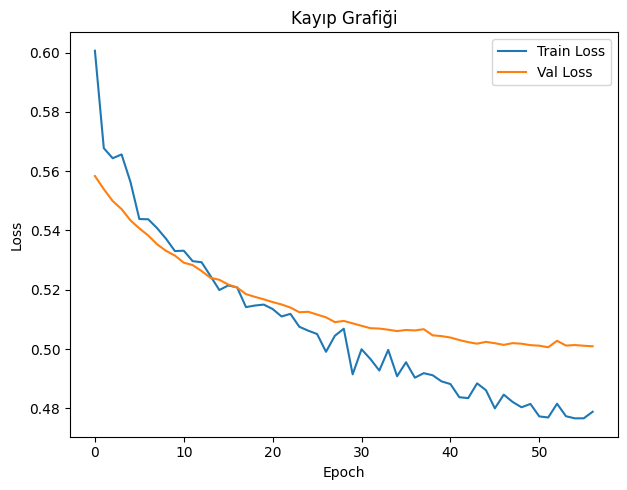

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Kayıp Grafiği")
plt.legend()

plt.tight_layout()
plt.show()


Test Loss       : 0.5838
Test Accuracy   : 0.3911
Inference Time  : 0.04 saniye

Confusion Matrix:
 [[ 83  63   9]
 [ 44  52  10]
 [ 53 162  84]]


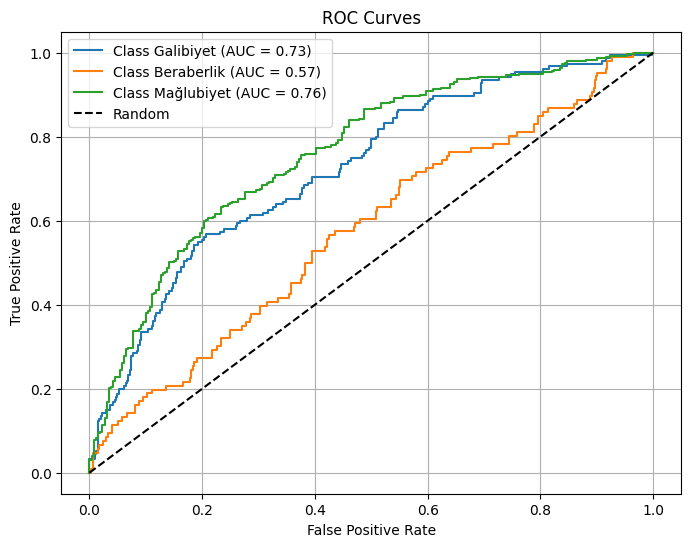

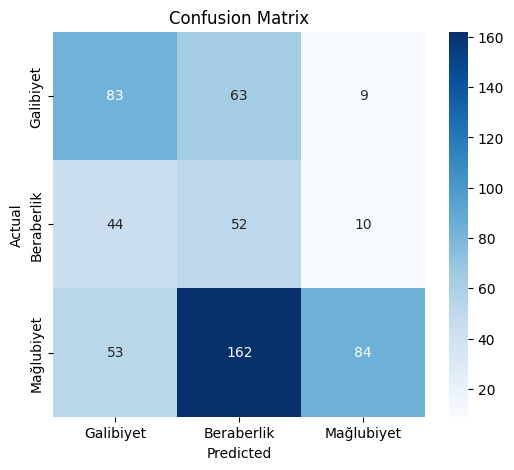


Classification Report:
              precision    recall  f1-score   support

   Galibiyet     0.4611    0.5355    0.4955       155
  Beraberlik     0.1877    0.4906    0.2715       106
  Mağlubiyet     0.8155    0.2809    0.4179       299

    accuracy                         0.3911       560
   macro avg     0.4881    0.4357    0.3950       560
weighted avg     0.5986    0.3911    0.4117       560


Class: Galibiyet
 - Sensitivity (Recall) : 0.5355
 - Specificity          : 0.7605

Class: Beraberlik
 - Sensitivity (Recall) : 0.4906
 - Specificity          : 0.5044

Class: Mağlubiyet
 - Sensitivity (Recall) : 0.2809
 - Specificity          : 0.9272


In [ ]:
# Model değerlendirme
model.eval()
all_preds = []
all_targets = []
all_probs = []

total_loss = 0
total_correct = 0
total_samples = 0

start_time = time.time()

with torch.no_grad():
    for x_seq, x_static, team_id, rival_id, labels in test_loader:
        x_seq, x_static = x_seq.to(device), x_static.to(device)
        team_id, rival_id = team_id.to(device), rival_id.to(device)
        labels = labels.to(device)

        outputs = model(x_seq, x_static, team_id, rival_id)
        probs = F.softmax(outputs, dim=1)
        preds = probs.argmax(dim=1)

        # Test kaybı ve doğruluğu hesapla
        loss = criterion(outputs, labels)
        total_loss += loss.item() * labels.size(0)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

        all_preds.append(preds.cpu().numpy())
        all_targets.append(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

end_time = time.time()
inference_time = end_time - start_time

# Ortalama kayıp ve doğruluk
avg_test_loss = total_loss / total_samples
test_accuracy = total_correct / total_samples

# Verileri birleştir
y_true = np.concatenate(all_targets)
y_pred = np.concatenate(all_preds)
y_prob = np.concatenate(all_probs)

# Accuracy
acc = accuracy_score(y_true, y_pred)

# Precision, Recall, F1
prec = precision_score(y_true, y_pred, average='macro')
rec  = recall_score(y_true, y_pred, average='macro')
f1   = f1_score(y_true, y_pred, average='macro')

print("\nTest Loss       : {:.4f}".format(avg_test_loss))
print("Test Accuracy   : {:.4f}".format(test_accuracy))
print("Inference Time  : {:.2f} saniye".format(inference_time))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['Galibiyet', 'Beraberlik', 'Mağlubiyet']
print("\nConfusion Matrix:\n", cm)

# Sensitivity = Recall
sensitivity = cm.diagonal() / cm.sum(axis=1)

# Specificity
specificity = []
for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp_fn = cm[:, i].sum() - cm[i, i]
    specificity.append(tn / (tn + fp_fn + 1e-6))
specificity = np.array(specificity)

# AUC Skoru
try:
    auc_score = roc_auc_score(
        y_true, y_prob, multi_class="ovr", average="macro"
    )
except:
    auc_score = None

# ROC Eğrisi çizimi
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_prob.shape[1]

for i in range(n_classes):
    y_true_bin = (y_true == i).astype(int)
    fpr[i], tpr[i], _ = roc_curve(y_true_bin, y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Ek metrikler
for i, class_name in enumerate(class_names):
    print(f"\nClass: {class_name}")
    print(f" - Sensitivity (Recall) : {sensitivity[i]:.4f}")
    print(f" - Specificity          : {specificity[i]:.4f}")
